In [1]:
library(NormqPCR)
library(pheatmap)
library(readxl)
library(plotrix)

Loading required package: RColorBrewer

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: ReadqPCR

Loading required package: qpcR

Loading required package: MASS

Loadi

In [2]:
######################################## 
### FUNCTION FOR RLE-PLOT AND RUV_total
########################################

RLEplot_mod <- function(data,pdata_group){
  
Color_Batches <- c('purple','orange','brown','blue','darkgreen','pink','gray','red','black','green','navy','Violet')
par(mar = c(6.5,6.5,2.3,0))
boxplot(data - rowMedians(data), main = '', xlab ='', ylab = '', xaxt = 'n', yaxt = 'n', ylim = c(-4.1,4.1),xlim=c(0,50),
        outline = FALSE, names = FALSE, frame = FALSE, whisklty = 3, whisklwd = 1.5, staplelty = 1, notch = TRUE, boxlwd = 2,
        staplelwd = 0 , boxcol = Color_Batches[factor(pdata_group)],
        border = Color_Batches[factor(pdata_group)], col = 'gray87')
box(lwd = 7, bty = 'l')
title('RLE plot', line = -2, cex.main = 3.5)
Median_Nano <- apply(data - rowMedians(data), 2, median)
points(c(1:ncol(data)), Median_Nano, col = Color_Batches[factor(pdata_group)], pch = 19, cex = 1.2)
axis(2, mgp = c(3.5, .9 ,0), lwd.ticks=6, las=1, cex.axis=3)
mtext('RLE', 2, line = 3.5, cex = 3.5)
abline(h = 0, col = 'black', lwd = 5, lty = 2)
par(lwd = 3)
axis.break(2, -4.2, style = 'zigzag', brw = .02)
x_labs <- levels(factor(colnames(data)))

text(x = seq_along(x_labs), y = -4.5, labels = x_labs, 
     srt = 90,    # rotate
     adj = 1,    # justify
     xpd = TRUE)    # plot in margin

legend(36, 4.1, legend = unique(factor(pdata_group)),
       col = unique(Color_Batches[factor(pdata_group)]),
       pch = 15, bty = 'n', cex = 1)
text(x = 40, y = 4.2 ,labels  = 'Run', cex = 1.5)

}

In [3]:
##### FUNCTION FOR RUVg  ### Bhattacharia et. al. 

RUV_total <- function(raw,pData,fData,k,hkgenes = NULL,exclude = NULL){
  
  library(RUVSeq)
  library(DESeq2)
  library(limma)
  library(matrixStats)
  
  if (!is.null(hkgenes)){
    
    fData(set)$CodeClass[rownames(set) %in% hkgenes] = 'Housekeeping'
    
  }
  
  
  fData = fData[rownames(raw),]
  int = intersect(rownames(raw),rownames(fData))
  fData = fData[int,]
  raw = raw[int,]
  
  set <- newSeqExpressionSet(as.matrix(round(raw)),
                             phenoData=pData,
                             featureData=fData)
  
  cIdx <- rownames(set)[fData(set)$`Class Name` == "Housekeeping"]
  cIdx = cIdx[!(cIdx %in% exclude)]
  x <- as.factor(pData$Group)
  set <- betweenLaneNormalization(set, which="upper")
  set <- RUVg(set, cIdx, k=k)
  dds <- DESeqDataSetFromMatrix(counts(set),colData=pData(set),design=~1)
  rowData(dds) <- fData
  dds <- estimateSizeFactors(dds)
  dds <- estimateDispersionsGeneEst(dds)
  cts <- counts(dds, normalized=TRUE)
  disp <- pmax((rowVars(cts) - rowMeans(cts)),0)/rowMeans(cts)^2
  mcols(dds)$dispGeneEst <- disp
  dds <- estimateDispersionsFit(dds, fitType="mean")
  vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
  mat <- assay(vsd)
  covars <- as.matrix(colData(dds)[,grep("W",colnames(colData(dds))),drop=FALSE])
#   mat_has_na = count(is.na(mat))
#   covar_has_na = count(is.na(covars))
#   if (mat_has_na > 0) {
#       print('mat has na values')
#   }
#   if (covar_has_na > 0) {
#       print('covar has na values')
#       print(covars)
#   }
  
  mat <- removeBatchEffect(mat, covariates=covars)
  assay(vsd) <- mat
  return(list(set = set,vsd = vsd))
  
}

In [4]:
RLEplot_mod <- function(data, pdata_group) {
  
  Color_Batches <- c('purple', 'orange', 'brown', 'blue', 'darkgreen', 'pink', 'gray', 'red', 'black', 'green', 'navy', 'Violet')
  
  par(mar = c(6.5, 6.5, 2.3, 2.3))  # Adjust the margin parameters
  par(plt = c(0.1, 0.9, 0.1, 0.9))  # Adjust the plot area parameters
  boxplot(data - rowMedians(data), main = '', xlab = '', ylab = '', xaxt = 'n', yaxt = 'n', ylim = c(-4.1, 4.1), xlim = c(0, 50),
          outline = FALSE, names = FALSE, frame = FALSE, whisklty = 3, whisklwd = 1.5, staplelty = 1, notch = TRUE, boxlwd = 2,
          staplelwd = 0, boxcol = Color_Batches[factor(pdata_group)],
          border = Color_Batches[factor(pdata_group)], col = 'gray87')
  box(lwd = 7, bty = 'l')
  title('RLE plot', line = -2, cex.main = 3.5)
  Median_Nano <- apply(data - rowMedians(data), 2, median)
  points(c(1:ncol(data)), Median_Nano, col = Color_Batches[factor(pdata_group)], pch = 19, cex = 1.2)
  axis(2, mgp = c(3.5, .9, 0), lwd.ticks = 6, las = 1, cex.axis = 3)
  mtext('RLE', 2, line = 3.5, cex = 3.5)
  abline(h = 0, col = 'black', lwd = 5, lty = 2)
  par(lwd = 3)
  axis.break(2, -4.2, style = 'zigzag', brw = .02)
  x_labs <- levels(factor(colnames(data)))
  text(x = seq_along(x_labs), y = -4.5, labels = x_labs,
       srt = 90,    # rotate
       adj = 1,    # justify
       xpd = TRUE)    # plot in margin
  
  legend(36, 4.1, legend = unique(factor(pdata_group)),
         col = unique(Color_Batches[factor(pdata_group)]),
         pch = 15, bty = 'n', cex = 1)
  text(x = 40, y = 4.2, labels = 'Run', cex = 1.5)
  
}

In [5]:
raw = read.csv('Data/raw_count_transponsed_raw.csv', row.names = 1, check.names = F )
norm_count = read.csv('Data/raw_count.csv', row.names = 1, check.names = F)
# sample annotations:
# annot = read.csv('Data/annot_3.csv', row.names = 1, check.names = F )
annot = read.csv('Data/annot_clinical.csv', row.names = 1, check.names = F )
# annot = read.csv('Data/annot_clinical_2.csv', row.names = 1, check.names = F )

# gene annotations:
gannot = read.csv('Data/gannot_raw.csv', row.names = 1, check.names = F )
old_gannot=read.csv('Data/gannot.csv', row.names = 1, check.names = F)
clin = read.csv('Data/annot.csv', row.names = 1, check.names = F )

In [6]:
raw_expression <- raw
dim(raw_expression)

[1] 784  48

In [7]:
fData=gannot
head(fData)

,Class Name,% Samples above Threshold,Immune Response Category,Accession,Common Name,Gene_Class
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
A2M,Endogenous,100,Chemokines,NM_000014.4,A2M,Immune Response
ABCB1,Endogenous,100,,NM_000927.3,ABCB1,Immune Response
ABCF1,Housekeeping,100,,NM_001090.2,ABCF1,HK
ABL1,Endogenous,100,"Cell Cycle, Regulation, Senescence",NM_005157.3,ABL,Immune Response
ADA,Endogenous,100,"B-Cell Functions, T-Cell Functions",NM_000022.2,ADA,Immune Response
ADORA2A,Endogenous,100,Cell Functions,NM_000675.3,ADORA2A,Immune Response - Checkpoint


In [8]:
fData$IsControl = fData$`Class Name`!='Endogenous'
# fData

In [9]:
pData <- annot

In [10]:
l1 = row.names(fData[fData$`Class Name`=='Negative',])
l2 = row.names(fData[fData$`Class Name`=='Positive',])

In [11]:
exclude= c(l1, l2)
exclude

[1] "NEG_A" "NEG_B" "NEG_C" "NEG_D" "NEG_E" "NEG_F" "NEG_G" "NEG_H" "POS_A"
[10] "POS_B" "POS_C" "POS_D" "POS_E" "POS_F"

In [12]:
cIdx <- rownames(raw_expression)
cIdx = cIdx[!(cIdx %in% exclude)]

In [13]:
# raw_expression_ex = raw_expression[cIdx,]
raw_expression_ex = raw_expression

In [14]:
pData <- annot[colnames(raw_expression),]
pData

,Conditions,Diagnosis,pid,Is_matched,Subject_ID,RECIST_response,TTP2n,group
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
20230616_210462891024_K1241-B_02.RCC,Soft Tissue Sarcoma,Baseline,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS
20230616_210462891024_K1628-B_03.RCC,Soft Tissue Sarcoma,Baseline,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K1865-B_04.RCC,Osteosarcoma,Baseline,K1865,False,TI0004,PD,PFS3.N,ADVANCED OSTEOSARCOMA
20230616_210462891024_K2032-B_05.RCC,Soft Tissue Sarcoma,Baseline,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2068-B_06.RCC,Soft Tissue Sarcoma,Baseline,K2068,False,TI0035,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2323-B_07.RCC,Soft Tissue Sarcoma,Baseline,K2323,False,TI0033,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2360-B_08.RCC,Soft Tissue Sarcoma,Baseline,K2360,True,TI0030,SD,PFS3.Y,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2520-B_09.RCC,Soft Tissue Sarcoma,Baseline,K2520,False,TI0012,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2669-B_10.RCC,Soft Tissue Sarcoma,Baseline,K2669,False,TI0059,SD,PFS3.Y,OTHER ADVANCED SARCOMAS


In [15]:
# fData_ex = fData[cIdx,]
fData_ex = fData

In [16]:
k = 3  
vsd = RUV_total(raw_expression_ex,pData,
                fData_ex,k = k)$vsd ## put exclude if there any hk associated with biology of interest 
set = RUV_total(raw_expression_ex,pData,
                fData_ex,k = k)$set # ,exclude = exc

Loading required package: EDASeq

Loading required package: ShortRead

Loading required package: BiocParallel

Loading required package: Biostrings

Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:Matrix’:

    expand, unname


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: XVector

Loading required package: GenomeInfoDb


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: Rsamtools

Loading required package: GenomicRanges

Loading required package: GenomicAlignments

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The followi

In [17]:
col_data = pData(set)
sorted_col_data <- col_data[order(col_data$pid) , ]
sorted_col_data <- sorted_col_data[sorted_col_data$Is_matched=='True',]
sorted_col_data

,Conditions,Diagnosis,pid,Is_matched,Subject_ID,RECIST_response,TTP2n,group,W_1,W_2,W_3
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
20230616_210462891024_K1241-B_02.RCC,Soft Tissue Sarcoma,Baseline,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,-0.009896901,-0.215404517,-0.501811288
20230707_210462871024_K1241-Tx_09.RCC,Soft Tissue Sarcoma,Treatment,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,-0.020844991,0.078711706,0.143567200
20230616_210462891024_K1628-B_03.RCC,Soft Tissue Sarcoma,Baseline,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.088272111,0.162233610,-0.026069855
20230707_210462871024_K1628-Tx_10.RCC,Soft Tissue Sarcoma,Treatment,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.148784059,0.059683647,0.134591727
20230616_210462891024_K2032-B_05.RCC,Soft Tissue Sarcoma,Baseline,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.118425078,0.061888426,-0.243062268
20230707_210462871024_K2032-Tx_11.RCC,Soft Tissue Sarcoma,Treatment,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.131786405,0.055331609,0.010885696
20230616_210462891024_K2360-B_08.RCC,Soft Tissue Sarcoma,Baseline,K2360,True,TI0030,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,0.030261488,-0.147169304,-0.125632503
20230707_210462871024_K2360-Tx_12.RCC,Soft Tissue Sarcoma,Treatment,K2360,True,TI0030,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,-0.001675416,-0.012513371,0.131826485
20230616_210462891024_K2742-B_11.RCC,Soft Tissue Sarcoma,Baseline,K2742,True,TI0015,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,0.335691596,-0.079589399,0.039050479


In [18]:
swap_rows <- function(df) {
  num_rows <- nrow(df)
  if (num_rows %% 2 != 0) {
    warning("The number of rows is not even; the last row will not be swapped.")
  }
  
  for (i in seq(1, num_rows, by = 2)) {
    if (i + 1 <= num_rows) {
      temp_row <- df[i, ]
      df[i, ] <- df[i + 1, ]
      df[i + 1, ] <- temp_row
    }
  }
  
  return(df)
}
swap_columns <- function(df) {
  num_cols <- ncol(df)
  if (num_cols %% 2 != 0) {
    warning("The number of columns is not even; the last column will not be swapped.")
  }
  
  for (i in seq(1, num_cols, by = 2)) {
    if (i + 1 <= num_cols) {
      temp_col <- df[, i]
      df[, i] <- df[, i + 1]
      df[, i + 1] <- temp_col
    }
  }
  
  return(df)
}

In [19]:
fData_ex = fData[cIdx,]

In [20]:
# fData_ex['']

In [21]:
k = 3  
vsd = RUV_total(raw_expression,pData,
                fData,k = k)$vsd ## put exclude if there any hk associated with biology of interest 
set = RUV_total(raw_expression,pData,
                fData,k = k)$set # ,exclude = exc

converting counts to integer mode

converting counts to integer mode



In [22]:
normalizedcount <- set@assayData[["normalizedCounts"]]

In [23]:
col_data = pData(set)
sorted_col_data <- col_data[order(col_data$pid) , ]
sorted_col_data <- sorted_col_data[sorted_col_data$Is_matched=='True',]
sorted_col_data

,Conditions,Diagnosis,pid,Is_matched,Subject_ID,RECIST_response,TTP2n,group,W_1,W_2,W_3
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
20230616_210462891024_K1241-B_02.RCC,Soft Tissue Sarcoma,Baseline,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,-0.009896901,-0.215404517,-0.501811288
20230707_210462871024_K1241-Tx_09.RCC,Soft Tissue Sarcoma,Treatment,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,-0.020844991,0.078711706,0.143567200
20230616_210462891024_K1628-B_03.RCC,Soft Tissue Sarcoma,Baseline,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.088272111,0.162233610,-0.026069855
20230707_210462871024_K1628-Tx_10.RCC,Soft Tissue Sarcoma,Treatment,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.148784059,0.059683647,0.134591727
20230616_210462891024_K2032-B_05.RCC,Soft Tissue Sarcoma,Baseline,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.118425078,0.061888426,-0.243062268
20230707_210462871024_K2032-Tx_11.RCC,Soft Tissue Sarcoma,Treatment,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.131786405,0.055331609,0.010885696
20230616_210462891024_K2360-B_08.RCC,Soft Tissue Sarcoma,Baseline,K2360,True,TI0030,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,0.030261488,-0.147169304,-0.125632503
20230707_210462871024_K2360-Tx_12.RCC,Soft Tissue Sarcoma,Treatment,K2360,True,TI0030,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,-0.001675416,-0.012513371,0.131826485
20230616_210462891024_K2742-B_11.RCC,Soft Tissue Sarcoma,Baseline,K2742,True,TI0015,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,0.335691596,-0.079589399,0.039050479


In [24]:
count_data = counts(set)

In [29]:
count_data['CXCL1',]

20230616_210462891024_K1241-B_02.RCC  20230616_210462891024_K1628-B_03.RCC 
                                    8                                    33 
 20230616_210462891024_K1865-B_04.RCC  20230616_210462891024_K2032-B_05.RCC 
                                   42                                    15 
 20230616_210462891024_K2068-B_06.RCC  20230616_210462891024_K2323-B_07.RCC 
                                   32                                    37 
 20230616_210462891024_K2360-B_08.RCC  20230616_210462891024_K2520-B_09.RCC 
                                   16                                    24 
 20230616_210462891024_K2669-B_10.RCC  20230616_210462891024_K2742-B_11.RCC 
                                   90                                    12 
 20230616_210462891024_K2849-B_12.RCC   20230616_210462891024_K853-B_01.RCC 
                                   10                                   365 
20230707_210462871024_K1241-Tx_09.RCC 20230707_210462871024_K1628-Tx_10.RCC 
                                   31                                    29 
20230707_210462871024_K2032-Tx_11.RCC 20230707_210462871024_K2360-Tx_12.RCC 
                                   27                                    14 
 20230707_210462871024_K4106-B_01.RCC  20230707_210462871024_K4196-B_02.RCC 
                                   56                                   167 
 20230707_210462871024_K4258-B_03.RCC  20230707_210462871024_K4307-B_04.RCC 
                                   14                                    29 
 20230707_210462871024_K4360-B_05.RCC  20230707_210462871024_K4368-B_06.RCC 
                                   17                                    44 
 20230707_210462871024_K5046-B_07.RCC  20230707_210462871024_K853-Tx_08.RCC 
                                   95                                   711 
 20230707_210462881024_K2894-B_01.RCC  20230707_210462881024_K2917-B_02.RCC 
                                  405                                    15 
 20230707_210462881024_K3056-B_03.RCC  20230707_210462881024_K3566-B_04.RCC 
                                   18                                     6 
 20230707_210462881024_K3812-B_05.RCC  20230707_210462881024_K3953-B_06.RCC 
                                   80                                   464 
 20230707_210462881024_K3975-B_07.RCC  20230707_210462881024_K4010-B_08.RCC 
                                   17                                    24 
 20230707_210462881024_K4020-B_09.RCC  20230707_210462881024_K4023-B_10.RCC 
                                   83                                    26 
 20230707_210462881024_K4054-B_11.RCC  20230707_210462881024_K4093-B_12.RCC 
                                  100                                   331 
20230707_210462901024_K2742-Tx_01.RCC 20230707_210462901024_K2849-Tx_02.RCC 
                                   12                                    42 
20230707_210462901024_K2894-Tx_03.RCC 20230707_210462901024_K2917-Tx_04.RCC 
                                  357                                    13 
20230707_210462901024_K3056-Tx_05.RCC 20230707_210462901024_K3566-Tx_06.RCC 
                                   33                                     9 
20230707_210462901024_K3953-Tx_07.RCC 20230707_210462901024_K3975-Tx_08.RCC 
                                  210                                    39 
20230707_210462901024_K4106-Tx_09.RCC 20230707_210462901024_K4258-Tx_10.RCC 
                                  164                                    39 
20230707_210462901024_K4360-Tx_11.RCC 20230707_210462901024_K4368-Tx_12.RCC 
                                   38                                     8

In [25]:
normalizedcount['CXCL1',]

20230616_210462891024_K1241-B_02.RCC  20230616_210462891024_K1628-B_03.RCC 
                                   96                                   117 
 20230616_210462891024_K1865-B_04.RCC  20230616_210462891024_K2032-B_05.RCC 
                                   25                                    47 
 20230616_210462891024_K2068-B_06.RCC  20230616_210462891024_K2323-B_07.RCC 
                                   51                                    65 
 20230616_210462891024_K2360-B_08.RCC  20230616_210462891024_K2520-B_09.RCC 
                                   15                                    37 
 20230616_210462891024_K2669-B_10.RCC  20230616_210462891024_K2742-B_11.RCC 
                                   45                                    28 
 20230616_210462891024_K2849-B_12.RCC   20230616_210462891024_K853-B_01.RCC 
                                   39                                   278 
20230707_210462871024_K1241-Tx_09.RCC 20230707_210462871024_K1628-Tx_10.RCC 
                                   30                                    42 
20230707_210462871024_K2032-Tx_11.RCC 20230707_210462871024_K2360-Tx_12.RCC 
                                   47                                    10 
 20230707_210462871024_K4106-B_01.RCC  20230707_210462871024_K4196-B_02.RCC 
                                   26                                   258 
 20230707_210462871024_K4258-B_03.RCC  20230707_210462871024_K4307-B_04.RCC 
                                   56                                    50 
 20230707_210462871024_K4360-B_05.RCC  20230707_210462871024_K4368-B_06.RCC 
                                   74                                    92 
 20230707_210462871024_K5046-B_07.RCC  20230707_210462871024_K853-Tx_08.RCC 
                                   30                                   277 
 20230707_210462881024_K2894-B_01.RCC  20230707_210462881024_K2917-B_02.RCC 
                                  115                                    79 
 20230707_210462881024_K3056-B_03.RCC  20230707_210462881024_K3566-B_04.RCC 
                                   14                                    19 
 20230707_210462881024_K3812-B_05.RCC  20230707_210462881024_K3953-B_06.RCC 
                                  149                                   160 
 20230707_210462881024_K3975-B_07.RCC  20230707_210462881024_K4010-B_08.RCC 
                                   16                                     8 
 20230707_210462881024_K4020-B_09.RCC  20230707_210462881024_K4023-B_10.RCC 
                                  171                                   127 
 20230707_210462881024_K4054-B_11.RCC  20230707_210462881024_K4093-B_12.RCC 
                                   27                                   431 
20230707_210462901024_K2742-Tx_01.RCC 20230707_210462901024_K2849-Tx_02.RCC 
                                   24                                   122 
20230707_210462901024_K2894-Tx_03.RCC 20230707_210462901024_K2917-Tx_04.RCC 
                                  195                                    33 
20230707_210462901024_K3056-Tx_05.RCC 20230707_210462901024_K3566-Tx_06.RCC 
                                   51                                    15 
20230707_210462901024_K3953-Tx_07.RCC 20230707_210462901024_K3975-Tx_08.RCC 
                                  193                                    92 
20230707_210462901024_K4106-Tx_09.RCC 20230707_210462901024_K4258-Tx_10.RCC 
                                   58                                   102 
20230707_210462901024_K4360-Tx_11.RCC 20230707_210462901024_K4368-Tx_12.RCC 
                                  238                                    17

In [26]:
reordered_count_data <- count_data[, rownames(sorted_col_data) ]
reordered_count_data

,20230616_210462891024_K1241-B_02.RCC,20230707_210462871024_K1241-Tx_09.RCC,20230616_210462891024_K1628-B_03.RCC,20230707_210462871024_K1628-Tx_10.RCC,20230616_210462891024_K2032-B_05.RCC,20230707_210462871024_K2032-Tx_11.RCC,20230616_210462891024_K2360-B_08.RCC,20230707_210462871024_K2360-Tx_12.RCC,20230616_210462891024_K2742-B_11.RCC,20230707_210462901024_K2742-Tx_01.RCC,⋯,20230707_210462871024_K4106-B_01.RCC,20230707_210462901024_K4106-Tx_09.RCC,20230707_210462871024_K4258-B_03.RCC,20230707_210462901024_K4258-Tx_10.RCC,20230707_210462871024_K4360-B_05.RCC,20230707_210462901024_K4360-Tx_11.RCC,20230707_210462871024_K4368-B_06.RCC,20230707_210462901024_K4368-Tx_12.RCC,20230616_210462891024_K853-B_01.RCC,20230707_210462871024_K853-Tx_08.RCC
A2M,45,2390,20742,9876,4893,3641,5259,8504,600,1826,⋯,485,2356,1001,724,1681,514,49846,25105,853,389
ABCB1,6,87,161,105,46,50,10,50,21,31,⋯,30,94,17,9,22,5,18,25,13,15
ABL1,16,1010,1557,858,707,636,286,453,508,750,⋯,69,182,197,287,1516,186,509,830,80,36
ADA,12,141,70,65,78,56,58,160,70,151,⋯,39,53,83,58,121,36,59,69,35,16
ADORA2A,3,34,27,76,24,32,58,248,14,40,⋯,16,28,20,19,27,20,25,46,17,16
AICDA,7,8,10,15,11,14,11,12,12,18,⋯,12,8,10,12,8,8,9,11,7,4
AIRE,12,26,10,22,20,36,15,24,21,24,⋯,9,16,18,14,20,12,18,18,11,30
AKT3,64,664,4438,1569,228,162,831,1273,60,156,⋯,821,2060,327,126,1497,283,1330,3283,388,268
ALCAM,12,237,1637,692,155,639,28,32,9,10,⋯,159,427,21,21,170,49,522,617,191,268
AMBP,4,8,3,3490,7,4,9,12,11,4,⋯,6,9272,4,5,9,5,5,8,5,6


In [27]:
sorted_col_data$ind.n <- factor(rep(rep(1:2,each=1),17))

In [28]:
sorted_col_data = swap_rows(sorted_col_data)
sorted_col_data

,Conditions,Diagnosis,pid,Is_matched,Subject_ID,RECIST_response,TTP2n,group,W_1,W_2,W_3,ind.n
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
20230616_210462891024_K1241-B_02.RCC,Soft Tissue Sarcoma,Treatment,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,-0.020844991,0.078711706,0.143567200,2
20230707_210462871024_K1241-Tx_09.RCC,Soft Tissue Sarcoma,Baseline,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,-0.009896901,-0.215404517,-0.501811288,1
20230616_210462891024_K1628-B_03.RCC,Soft Tissue Sarcoma,Treatment,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.148784059,0.059683647,0.134591727,2
20230707_210462871024_K1628-Tx_10.RCC,Soft Tissue Sarcoma,Baseline,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.088272111,0.162233610,-0.026069855,1
20230616_210462891024_K2032-B_05.RCC,Soft Tissue Sarcoma,Treatment,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.131786405,0.055331609,0.010885696,2
20230707_210462871024_K2032-Tx_11.RCC,Soft Tissue Sarcoma,Baseline,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.118425078,0.061888426,-0.243062268,1
20230616_210462891024_K2360-B_08.RCC,Soft Tissue Sarcoma,Treatment,K2360,True,TI0030,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,-0.001675416,-0.012513371,0.131826485,2
20230707_210462871024_K2360-Tx_12.RCC,Soft Tissue Sarcoma,Baseline,K2360,True,TI0030,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,0.030261488,-0.147169304,-0.125632503,1
20230616_210462891024_K2742-B_11.RCC,Soft Tissue Sarcoma,Treatment,K2742,True,TI0015,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,0.294082671,0.013429713,0.099779299,2


In [29]:
reordered_count_data = swap_columns(reordered_count_data)
reordered_count_data

,20230616_210462891024_K1241-B_02.RCC,20230707_210462871024_K1241-Tx_09.RCC,20230616_210462891024_K1628-B_03.RCC,20230707_210462871024_K1628-Tx_10.RCC,20230616_210462891024_K2032-B_05.RCC,20230707_210462871024_K2032-Tx_11.RCC,20230616_210462891024_K2360-B_08.RCC,20230707_210462871024_K2360-Tx_12.RCC,20230616_210462891024_K2742-B_11.RCC,20230707_210462901024_K2742-Tx_01.RCC,⋯,20230707_210462871024_K4106-B_01.RCC,20230707_210462901024_K4106-Tx_09.RCC,20230707_210462871024_K4258-B_03.RCC,20230707_210462901024_K4258-Tx_10.RCC,20230707_210462871024_K4360-B_05.RCC,20230707_210462901024_K4360-Tx_11.RCC,20230707_210462871024_K4368-B_06.RCC,20230707_210462901024_K4368-Tx_12.RCC,20230616_210462891024_K853-B_01.RCC,20230707_210462871024_K853-Tx_08.RCC
A2M,2390,45,9876,20742,3641,4893,8504,5259,1826,600,⋯,2356,485,724,1001,514,1681,25105,49846,389,853
ABCB1,87,6,105,161,50,46,50,10,31,21,⋯,94,30,9,17,5,22,25,18,15,13
ABL1,1010,16,858,1557,636,707,453,286,750,508,⋯,182,69,287,197,186,1516,830,509,36,80
ADA,141,12,65,70,56,78,160,58,151,70,⋯,53,39,58,83,36,121,69,59,16,35
ADORA2A,34,3,76,27,32,24,248,58,40,14,⋯,28,16,19,20,20,27,46,25,16,17
AICDA,8,7,15,10,14,11,12,11,18,12,⋯,8,12,12,10,8,8,11,9,4,7
AIRE,26,12,22,10,36,20,24,15,24,21,⋯,16,9,14,18,12,20,18,18,30,11
AKT3,664,64,1569,4438,162,228,1273,831,156,60,⋯,2060,821,126,327,283,1497,3283,1330,268,388
ALCAM,237,12,692,1637,639,155,32,28,10,9,⋯,427,159,21,21,49,170,617,522,268,191
AMBP,8,4,3490,3,4,7,12,9,4,11,⋯,9272,6,5,4,5,9,8,5,6,5


In [30]:
# dds_w1_2 <- DESeqDataSetFromMatrix(countData = reordered_count_data,
#                               colData = sorted_col_data,
#                                    design= ~ W_1 +  Diagnosis+pid) #counts(set)[1:652,], ##use design with W_1 or W_2 based on k value
dds_w1_2 <- DESeqDataSetFromMatrix(countData = reordered_count_data,
                              colData = sorted_col_data,
                                   design= ~ W_1 +  Diagnosis ) #counts(set)[1:652,], ##use design with W_1 or W_2 based on k value
dds_w1_2 <- DESeq(dds_w1_2)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, an

In [31]:
firstC <- 'Treatment'
SecondC <- 'Baseline'
contrast<- c("Diagnosis",firstC,SecondC)

In [32]:
res1_2 <- results(dds_w1_2, name="Diagnosis_.Treatment_vs_.Baseline")
res_deseq2_2 <- as.data.frame(results(dds_w1_2))
nam <- paste('up_in',firstC, sep = '_')
res_deseq2_2[, nam] <- as.logical(res_deseq2_2$log2FoldChange > 0)

res_deseq2_2$threshold <- as.logical(res_deseq2_2$padj < 0.05)  #Threshold defined earlier
row.names(res_deseq2_2)[which(res_deseq2_2$threshold)]

[1] "AMBP"     "ARG1"     "BCL2"     "BCL6"     "C4BPA"    "C8A"     
 [7] "C8B"      "C9"       "CCL19"    "CHUK"     "CRP"      "CTLA4"   
[13] "EGR1"     "F12"      "FADD"     "FOS"      "FYN"      "HAMP"    
[19] "HLA-DMB"  "HLA-DPA1" "HLA-DPB1" "HLA-DRA"  "ICOSLG"   "IL24"    
[25] "IRF3"     "MAP2K2"   "MASP2"    "MRC1"     "NFATC1"   "NFATC2"  
[31] "PSMD7"    "STAT3"    "TBK1"     "TNF"      "ERCC3"    "SF3A3"

In [33]:
res_valcanoplot2 <- results(dds_w1_2)

In [37]:
# res_valcanoplot2$log2FoldChange <- res_valcanoplot2$log2FoldChange * -1

In [34]:
library(EnhancedVolcano)
library('tidyr')

Loading required package: ggplot2

Loading required package: ggrepel


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




In [115]:
dim(counts(dds_w1_2))

[1] 784  34

In [117]:
# counts(dds_w1_2,normalized=TRUE)

In [35]:
norm_mean_w1_2 <- sapply( levels(dds_w1_2$Diagnosis), function(lvl) rowMeans( counts(dds_w1_2,normalized=TRUE)[,dds_w1_2$Diagnosis == lvl, drop=F] ) )
colnames(norm_mean_w1_2) <- paste('Rowmean_exp_',levels(dds_w1_2$Diagnosis),sep='')
res3_2 <- cbind(norm_mean_w1_2,res_deseq2_2)
top_de_genes_2 = na.omit(res3_2[res3_2$threshold==TRUE,])
top_de_genes_2        

,Rowmean_exp_ Baseline,Rowmean_exp_ Treatment,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_Treatment,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
AMBP,8.233202,557.82693,283.03007,5.9517285,0.8937728,6.659107,2.754967e-11,2.074490e-08,TRUE,TRUE
ARG1,7.194900,68.34735,37.77112,3.2442108,0.6771058,4.791291,1.657116e-06,1.782583e-04,TRUE,TRUE
BCL2,262.028834,120.59937,191.31410,-1.0525779,0.3256213,-3.232522,1.227028e-03,3.154205e-02,FALSE,TRUE
BCL6,270.597493,141.37643,205.98696,-0.9203122,0.2909999,-3.162586,1.563743e-03,3.620548e-02,FALSE,TRUE
C4BPA,4.960779,50.48767,27.72422,3.4423904,0.6688997,5.146348,2.656064e-07,3.333360e-05,TRUE,TRUE
C8A,9.521822,38.77867,24.15024,2.0843355,0.4953095,4.208148,2.574723e-05,1.762515e-03,TRUE,TRUE
C8B,7.048619,60.99586,34.02224,3.1208832,0.5464326,5.711378,1.120648e-08,2.812826e-06,TRUE,TRUE
C9,12.953218,122.76080,67.85701,3.2328038,0.6158845,5.249043,1.528918e-07,2.878188e-05,TRUE,TRUE
CCL19,78.237498,37.06042,57.64896,-1.2151483,0.4000061,-3.037824,2.382927e-03,4.984289e-02,FALSE,TRUE


In [25]:
write.csv(top_de_genes_2, file = 'DEseq2_DGE_Baseline_vs_Treatment.csv')

In [73]:
log2(160.75479/94.87607)

[1] 0.7607456

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


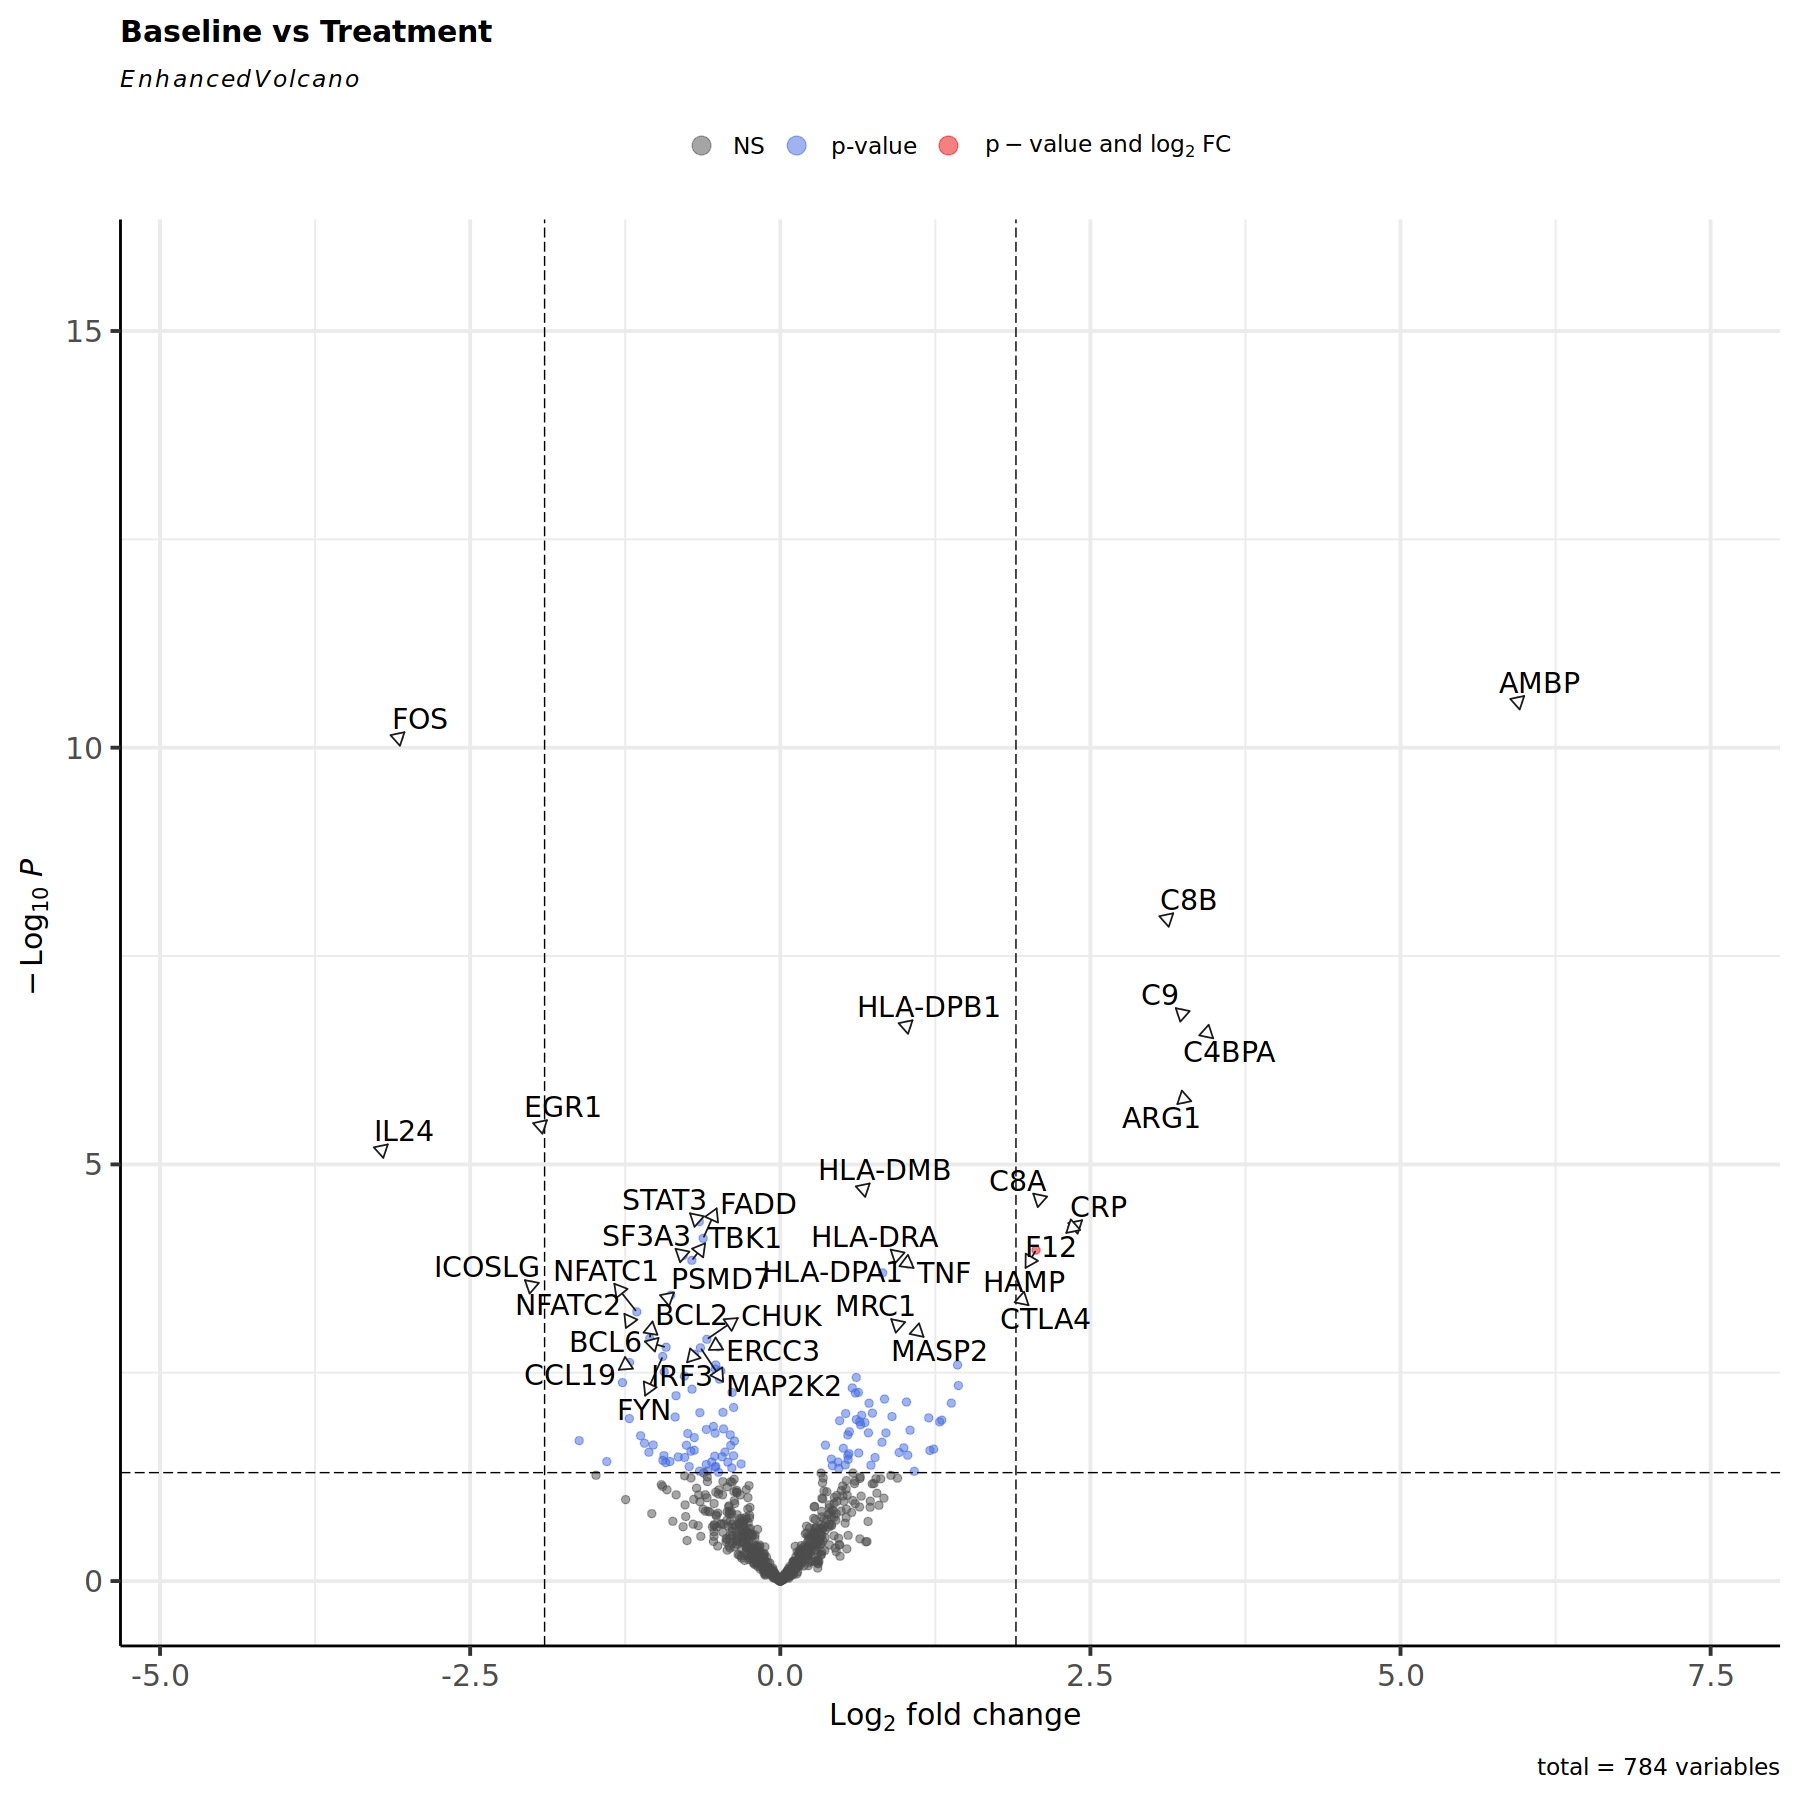

In [36]:
options(repr.plot.width=15, repr.plot.height=15)
EnhancedVolcano(res_valcanoplot2,
                lab = rownames(res_valcanoplot2),
                selectLab = row.names(top_de_genes_2),
                x = 'log2FoldChange',
                y = 'pvalue',
                title = 'Baseline vs Treatment',drawConnectors = TRUE,max.overlaps = 36,
                pCutoff = 0.05,
                FCcutoff = 1.9,
                pointSize = 2.0,
                labSize = 6.0)

In [121]:
options(repr.plot.width=17, repr.plot.height=17)
# pdf("01_SD_vs_PD_volcano_plot.pdf")
# jpeg('01_SD_vs_PD_volcano_plot.jpg')

# dev.off()
# sdvspd_volplot
pdf("05_Baseline_vs_Treatment_volcano_plot_(without_matched_cases).pdf", width=15, height=15)
print(EnhancedVolcano(res_valcanoplot2,
                lab = rownames(res_valcanoplot2),
                selectLab = row.names(top_de_genes_2),
                x = 'log2FoldChange',
                y = 'pvalue',
                title = 'Baseline vs Treatment (without matched cases)',drawConnectors = TRUE,max.overlaps = 35,
                pCutoff = 0.05,
                FCcutoff = 1.9,
                pointSize = 1.5,
                labSize = 6.0))
graphics.off()

In [122]:
goi = c('FOS', 'EGR1', 'AMBP', 'C8B')

In [123]:
colData(dds_w1_2)
tcounts <- t(log2((counts(dds_w1_2[goi, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(dds_w1_2), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goi)+1):ncol(.))
# tcounts

DataFrame with 34 rows and 13 columns
                                                Conditions  Diagnosis
                                               <character>   <factor>
20230616_210462891024_K1241-B_02.RCC  Soft Tissue Sarcoma   Treatment
20230707_210462871024_K1241-Tx_09.RCC Soft Tissue Sarcoma   Baseline 
20230616_210462891024_K1628-B_03.RCC  Soft Tissue Sarcoma   Treatment
20230707_210462871024_K1628-Tx_10.RCC Soft Tissue Sarcoma   Baseline 
20230616_210462891024_K2032-B_05.RCC  Soft Tissue Sarcoma   Treatment
...                                                    ...        ...
20230707_210462901024_K4360-Tx_11.RCC        Osteosarcoma   Baseline 
20230707_210462871024_K4368-B_06.RCC  Soft Tissue Sarcoma   Treatment
20230707_210462901024_K4368-Tx_12.RCC Soft Tissue Sarcoma   Baseline 
20230616_210462891024_K853-B_01.RCC          Osteosarcoma   Treatment
20230707_210462871024_K853-Tx_08.RCC         Osteosarcoma   Baseline 
                                              pid  I

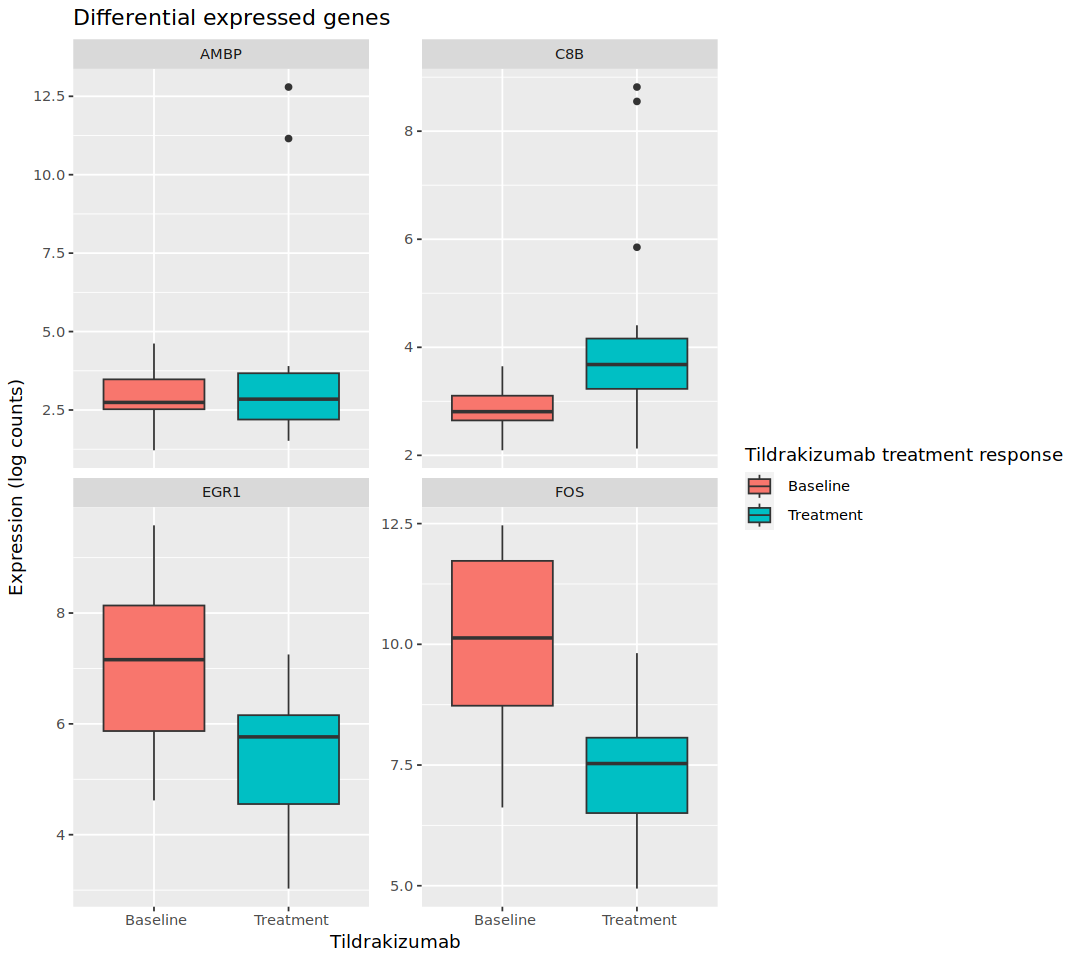

In [124]:
options(repr.plot.width=9, repr.plot.height=8)
sd_boxplot = ggplot(tcounts, aes(Diagnosis, expression, fill=Diagnosis)) + 
  geom_boxplot() + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Tildrakizumab", 
       y="Expression (log counts)", 
       fill="Tildrakizumab treatment response", 
       title="Differential expressed genes")
sd_boxplot

In [125]:
pdf("05_Baseline_vs_Treatment_box_plot_top_DE_genes_(without_matched_cases).pdf", width=8, height=8)
print(sd_boxplot)
graphics.off()

In [60]:
reordered_count_data

,20230616_210462891024_K1241-B_02.RCC,20230707_210462871024_K1241-Tx_09.RCC,20230616_210462891024_K1628-B_03.RCC,20230707_210462871024_K1628-Tx_10.RCC,20230616_210462891024_K2032-B_05.RCC,20230707_210462871024_K2032-Tx_11.RCC,20230616_210462891024_K2360-B_08.RCC,20230707_210462871024_K2360-Tx_12.RCC,20230616_210462891024_K2742-B_11.RCC,20230707_210462901024_K2742-Tx_01.RCC,⋯,20230707_210462871024_K4106-B_01.RCC,20230707_210462901024_K4106-Tx_09.RCC,20230707_210462871024_K4258-B_03.RCC,20230707_210462901024_K4258-Tx_10.RCC,20230707_210462871024_K4360-B_05.RCC,20230707_210462901024_K4360-Tx_11.RCC,20230707_210462871024_K4368-B_06.RCC,20230707_210462901024_K4368-Tx_12.RCC,20230616_210462891024_K853-B_01.RCC,20230707_210462871024_K853-Tx_08.RCC
A2M,2390,45,9876,20742,3641,4893,8504,5259,1826,600,⋯,2356,485,724,1001,514,1681,25105,49846,389,853
ABCB1,87,6,105,161,50,46,50,10,31,21,⋯,94,30,9,17,5,22,25,18,15,13
ABL1,1010,16,858,1557,636,707,453,286,750,508,⋯,182,69,287,197,186,1516,830,509,36,80
ADA,141,12,65,70,56,78,160,58,151,70,⋯,53,39,58,83,36,121,69,59,16,35
ADORA2A,34,3,76,27,32,24,248,58,40,14,⋯,28,16,19,20,20,27,46,25,16,17
AICDA,8,7,15,10,14,11,12,11,18,12,⋯,8,12,12,10,8,8,11,9,4,7
AIRE,26,12,22,10,36,20,24,15,24,21,⋯,16,9,14,18,12,20,18,18,30,11
AKT3,664,64,1569,4438,162,228,1273,831,156,60,⋯,2060,821,126,327,283,1497,3283,1330,268,388
ALCAM,237,12,692,1637,639,155,32,28,10,9,⋯,427,159,21,21,49,170,617,522,268,191
AMBP,8,4,3490,3,4,7,12,9,4,11,⋯,9272,6,5,4,5,9,8,5,6,5


In [27]:
reordered_count_data = swap_columns(reordered_count_data)
reordered_count_data

,20230616_210462891024_K1241-B_02.RCC,20230707_210462871024_K1241-Tx_09.RCC,20230616_210462891024_K1628-B_03.RCC,20230707_210462871024_K1628-Tx_10.RCC,20230616_210462891024_K2032-B_05.RCC,20230707_210462871024_K2032-Tx_11.RCC,20230616_210462891024_K2360-B_08.RCC,20230707_210462871024_K2360-Tx_12.RCC,20230616_210462891024_K2742-B_11.RCC,20230707_210462901024_K2742-Tx_01.RCC,⋯,20230707_210462871024_K4106-B_01.RCC,20230707_210462901024_K4106-Tx_09.RCC,20230707_210462871024_K4258-B_03.RCC,20230707_210462901024_K4258-Tx_10.RCC,20230707_210462871024_K4360-B_05.RCC,20230707_210462901024_K4360-Tx_11.RCC,20230707_210462871024_K4368-B_06.RCC,20230707_210462901024_K4368-Tx_12.RCC,20230616_210462891024_K853-B_01.RCC,20230707_210462871024_K853-Tx_08.RCC
A2M,45,2390,20742,9876,4893,3641,5259,8504,600,1826,⋯,485,2356,1001,724,1681,514,49846,25105,853,389
ABCB1,6,87,161,105,46,50,10,50,21,31,⋯,30,94,17,9,22,5,18,25,13,15
ABL1,16,1010,1557,858,707,636,286,453,508,750,⋯,69,182,197,287,1516,186,509,830,80,36
ADA,12,141,70,65,78,56,58,160,70,151,⋯,39,53,83,58,121,36,59,69,35,16
ADORA2A,3,34,27,76,24,32,58,248,14,40,⋯,16,28,20,19,27,20,25,46,17,16
AICDA,7,8,10,15,11,14,11,12,12,18,⋯,12,8,10,12,8,8,9,11,7,4
AIRE,12,26,10,22,20,36,15,24,21,24,⋯,9,16,18,14,20,12,18,18,11,30
AKT3,64,664,4438,1569,228,162,831,1273,60,156,⋯,821,2060,327,126,1497,283,1330,3283,388,268
ALCAM,12,237,1637,692,155,639,28,32,9,10,⋯,159,427,21,21,170,49,522,617,191,268
AMBP,4,8,3,3490,7,4,9,12,11,4,⋯,6,9272,4,5,9,5,5,8,5,6


In [62]:
reordered_count_data['CXCL1',]

20230616_210462891024_K1241-B_02.RCC 20230707_210462871024_K1241-Tx_09.RCC 
                                   31                                     8 
 20230616_210462891024_K1628-B_03.RCC 20230707_210462871024_K1628-Tx_10.RCC 
                                   29                                    33 
 20230616_210462891024_K2032-B_05.RCC 20230707_210462871024_K2032-Tx_11.RCC 
                                   27                                    15 
 20230616_210462891024_K2360-B_08.RCC 20230707_210462871024_K2360-Tx_12.RCC 
                                   14                                    16 
 20230616_210462891024_K2742-B_11.RCC 20230707_210462901024_K2742-Tx_01.RCC 
                                   12                                    12 
 20230616_210462891024_K2849-B_12.RCC 20230707_210462901024_K2849-Tx_02.RCC 
                                   42                                    10 
 20230707_210462881024_K2894-B_01.RCC 20230707_210462901024_K2894-Tx_03.RCC 
                                  357                                   405 
 20230707_210462881024_K2917-B_02.RCC 20230707_210462901024_K2917-Tx_04.RCC 
                                   13                                    15 
 20230707_210462881024_K3056-B_03.RCC 20230707_210462901024_K3056-Tx_05.RCC 
                                   33                                    18 
 20230707_210462881024_K3566-B_04.RCC 20230707_210462901024_K3566-Tx_06.RCC 
                                    9                                     6 
 20230707_210462881024_K3953-B_06.RCC 20230707_210462901024_K3953-Tx_07.RCC 
                                  210                                   464 
 20230707_210462881024_K3975-B_07.RCC 20230707_210462901024_K3975-Tx_08.RCC 
                                   39                                    17 
 20230707_210462871024_K4106-B_01.RCC 20230707_210462901024_K4106-Tx_09.RCC 
                                  164                                    56 
 20230707_210462871024_K4258-B_03.RCC 20230707_210462901024_K4258-Tx_10.RCC 
                                   39                                    14 
 20230707_210462871024_K4360-B_05.RCC 20230707_210462901024_K4360-Tx_11.RCC 
                                   38                                    17 
 20230707_210462871024_K4368-B_06.RCC 20230707_210462901024_K4368-Tx_12.RCC 
                                    8                                    44 
  20230616_210462891024_K853-B_01.RCC  20230707_210462871024_K853-Tx_08.RCC 
                                  711                                   365

In [63]:
dds_w1_2 <- DESeqDataSetFromMatrix(countData = reordered_count_data,
                              colData = sorted_col_data,
                                   design= ~ W_1 +  Diagnosis+pid) #counts(set)[1:652,], ##use design with W_1 or W_2 based on k value
# dds_w1_2 <- DESeq(dds_w1_2)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [68]:
# sorted_col_data

In [65]:
dds_w1_2 <- DESeq(dds_w1_2)

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and t

In [69]:
results(dds_w1_2)

log2 fold change (MLE): pid K853 vs K1241 
Wald test p-value: pid K853 vs K1241 
DataFrame with 784 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat     pvalue      padj
         <numeric>      <numeric> <numeric> <numeric>  <numeric> <numeric>
A2M      3947.2363       0.462025  0.750502  0.615622 0.53814433 0.8083693
ABCB1      32.6164      -0.551976  0.733586 -0.752435 0.45178950 0.7616400
ABL1      398.6766      -1.847805  0.664144 -2.782236 0.00539857 0.0640561
ADA        56.9104      -0.785892  0.501438 -1.567279 0.11704948 0.4223364
ADORA2A    28.4996       0.760389  0.673051  1.129764 0.25857565 0.6183767
...            ...            ...       ...       ...        ...       ...
POS_B   11866.5919      -0.337068  0.819765 -0.411177   0.680943  0.862512
POS_C    3304.9574      -0.358436  0.795048 -0.450835   0.652108  0.858949
POS_D     731.3730      -0.428462  0.751319 -0.570280   0.568488  0.826766
POS_E     125.3046      -0.426750  0.784252 -0.544150   

In [71]:
# reordered_count_data

In [44]:
firstC <- 'Treatment'
SecondC <- 'Baseline'
contrast<- c("Diagnosis",SecondC,firstC)

In [45]:
results(dds_w1_2)

log2 fold change (MLE): pid K853 vs K1241 
Wald test p-value: pid K853 vs K1241 
DataFrame with 784 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat     pvalue      padj
         <numeric>      <numeric> <numeric> <numeric>  <numeric> <numeric>
A2M      3947.2363       0.462025  0.750502  0.615622 0.53814433 0.8083693
ABCB1      32.6164      -0.551976  0.733586 -0.752435 0.45178950 0.7616400
ABL1      398.6766      -1.847805  0.664144 -2.782236 0.00539857 0.0640561
ADA        56.9104      -0.785892  0.501438 -1.567279 0.11704948 0.4223364
ADORA2A    28.4996       0.760389  0.673051  1.129764 0.25857565 0.6183767
...            ...            ...       ...       ...        ...       ...
POS_B   11866.5919      -0.337068  0.819765 -0.411177   0.680943  0.862512
POS_C    3304.9574      -0.358436  0.795048 -0.450835   0.652108  0.858949
POS_D     731.3730      -0.428462  0.751319 -0.570280   0.568488  0.826766
POS_E     125.3046      -0.426750  0.784252 -0.544150   

In [55]:
res1_2 <- results(dds_w1_2, name="Diagnosis_.Treatment_vs_.Baseline")
res_deseq2_2 <- as.data.frame(results(dds_w1_2))
nam <- paste('up_in',firstC, sep = '_')
res_deseq2_2[, nam] <- as.logical(res_deseq2_2$log2FoldChange > 0)

res_deseq2_2$threshold <- as.logical(res_deseq2_2$padj < 0.05)  #Threshold defined earlier
row.names(res_deseq2_2)[which(res_deseq2_2$threshold)]

[1] "ALCAM"    "ANP32B"   "BIRC5"    "C4B"      "CD276"    "CD40"    
 [7] "CD99"     "CDK1"     "COL3A1"   "CREB1"    "CXCL1"    "DUSP4"   
[13] "GZMA"     "HLA-DRB4" "IFI16"    "IL1R1"    "IL21R"    "ITGB4"   
[19] "ITK"      "KLRC2"    "LAMP2"    "LCP1"     "LRRN3"    "MAGEA3"  
[25] "MAP2K4"   "MICB"     "MME"      "NCAM1"    "NFATC4"   "PDGFC"   
[31] "PLAU"     "PTPRC"    "RORC"     "RUNX3"    "S100B"    "SMPD3"   
[37] "TCF7"     "TICAM2"   "TLR7"     "TNFSF15"  "TTK"      "USP9Y"   
[43] "VCAM1"    "VEGFC"    "FCF1"     "SF3A3"    "ZC3H14"

In [59]:
res_deseq2_2

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_Treatment,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
A2M,3947.23630,0.46202524,0.7505021,0.61562154,0.538144334,0.80836926,TRUE,FALSE
ABCB1,32.61640,-0.55197567,0.7335858,-0.75243501,0.451789497,0.76163998,FALSE,FALSE
ABL1,398.67662,-1.84780460,0.6641436,-2.78223646,0.005398569,0.06405610,FALSE,FALSE
ADA,56.91045,-0.78589249,0.5014375,-1.56727904,0.117049482,0.42233644,FALSE,FALSE
ADORA2A,28.49961,0.76038886,0.6730510,1.12976407,0.258575650,0.61837665,TRUE,FALSE
AICDA,14.93253,-0.50412144,0.8199066,-0.61485230,0.538652268,NA,FALSE,NA
AIRE,19.43108,-0.17249145,0.7859625,-0.21946523,0.826287659,0.92358603,FALSE,FALSE
AKT3,651.15205,0.53212379,0.5749504,0.92551259,0.354699340,0.67965681,TRUE,FALSE
ALCAM,192.21464,2.14721396,0.6932886,3.09714306,0.001953956,0.03444544,TRUE,TRUE


In [56]:
resultsNames(dds_w1_2)

[1] "Intercept"                         "W_1"                              
 [3] "Diagnosis_.Treatment_vs_.Baseline" "pid_K1628_vs_K1241"               
 [5] "pid_K2032_vs_K1241"                "pid_K2360_vs_K1241"               
 [7] "pid_K2742_vs_K1241"                "pid_K2849_vs_K1241"               
 [9] "pid_K2894_vs_K1241"                "pid_K2917_vs_K1241"               
[11] "pid_K3056_vs_K1241"                "pid_K3566_vs_K1241"               
[13] "pid_K3953_vs_K1241"                "pid_K3975_vs_K1241"               
[15] "pid_K4106_vs_K1241"                "pid_K4258_vs_K1241"               
[17] "pid_K4360_vs_K1241"                "pid_K4368_vs_K1241"               
[19] "pid_K853_vs_K1241"

In [57]:
res_valcanoplot2 <- results(dds_w1_2)

In [50]:
# res_valcanoplot2$log2FoldChange <- res_valcanoplot2$log2FoldChange * -1

In [58]:
norm_mean_w1_2 <- sapply( levels(dds_w1_2$Diagnosis), function(lvl) rowMeans( counts(dds_w1_2,normalized=TRUE)[,dds_w1_2$Diagnosis == lvl, drop=F] ) )
colnames(norm_mean_w1_2) <- paste('Rowmean_exp_',levels(dds_w1_2$Diagnosis),sep='')
res3_2 <- cbind(norm_mean_w1_2,res_deseq2_2)
top_de_genes_2 = na.omit(res3_2[res3_2$threshold==TRUE,])
top_de_genes_2   

,Rowmean_exp_ Baseline,Rowmean_exp_ Treatment,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_Treatment,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
ALCAM,188.70571,195.72357,192.21464,2.147214,0.6932886,3.097143,1.953956e-03,3.444544e-02,TRUE,TRUE
ANP32B,444.29411,372.50956,408.40184,-1.458484,0.4769578,-3.057889,2.229020e-03,3.717041e-02,FALSE,TRUE
BIRC5,136.69353,107.28430,121.98892,-2.250796,0.6381682,-3.526964,4.203538e-04,1.127645e-02,FALSE,TRUE
C4B,190.22125,223.38805,206.80465,3.867406,1.1692861,3.307494,9.413480e-04,2.002799e-02,TRUE,TRUE
CD276,1011.78046,841.50736,926.64391,-2.097007,0.6904399,-3.037205,2.387832e-03,3.877086e-02,FALSE,TRUE
CD40,127.56449,156.18342,141.87396,1.958189,0.5408779,3.620390,2.941589e-04,9.074803e-03,TRUE,TRUE
CD99,2615.15746,1671.50136,2143.32941,-3.493809,0.8681361,-4.024495,5.709776e-05,2.516380e-03,FALSE,TRUE
CDK1,212.94500,162.45045,187.69773,-2.777313,0.6570120,-4.227188,2.366303e-05,1.601390e-03,FALSE,TRUE
COL3A1,38320.62989,24979.01075,31649.82032,-2.870514,0.9868922,-2.908640,3.630047e-03,4.765402e-02,FALSE,TRUE


In [34]:
write.csv(top_de_genes_2, file = 'DEseq2_DGE_Baseline_vs_Treatment_wrt_pid.csv')

In [54]:
195.72357/188.70571

[1] 1.037189

In [53]:
top_de_genes_2

,Rowmean_exp_ Baseline,Rowmean_exp_ Treatment,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_Treatment,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
ALCAM,188.70571,195.72357,192.21464,2.147214,0.6932886,3.097143,1.953956e-03,3.444544e-02,TRUE,TRUE
ANP32B,444.29411,372.50956,408.40184,-1.458484,0.4769578,-3.057889,2.229020e-03,3.717041e-02,FALSE,TRUE
BIRC5,136.69353,107.28430,121.98892,-2.250796,0.6381682,-3.526964,4.203538e-04,1.127645e-02,FALSE,TRUE
C4B,190.22125,223.38805,206.80465,3.867406,1.1692861,3.307494,9.413480e-04,2.002799e-02,TRUE,TRUE
CD276,1011.78046,841.50736,926.64391,-2.097007,0.6904399,-3.037205,2.387832e-03,3.877086e-02,FALSE,TRUE
CD40,127.56449,156.18342,141.87396,1.958189,0.5408779,3.620390,2.941589e-04,9.074803e-03,TRUE,TRUE
CD99,2615.15746,1671.50136,2143.32941,-3.493809,0.8681361,-4.024495,5.709776e-05,2.516380e-03,FALSE,TRUE
CDK1,212.94500,162.45045,187.69773,-2.777313,0.6570120,-4.227188,2.366303e-05,1.601390e-03,FALSE,TRUE
COL3A1,38320.62989,24979.01075,31649.82032,-2.870514,0.9868922,-2.908640,3.630047e-03,4.765402e-02,FALSE,TRUE


Warning message:
“ggrepel: 26 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


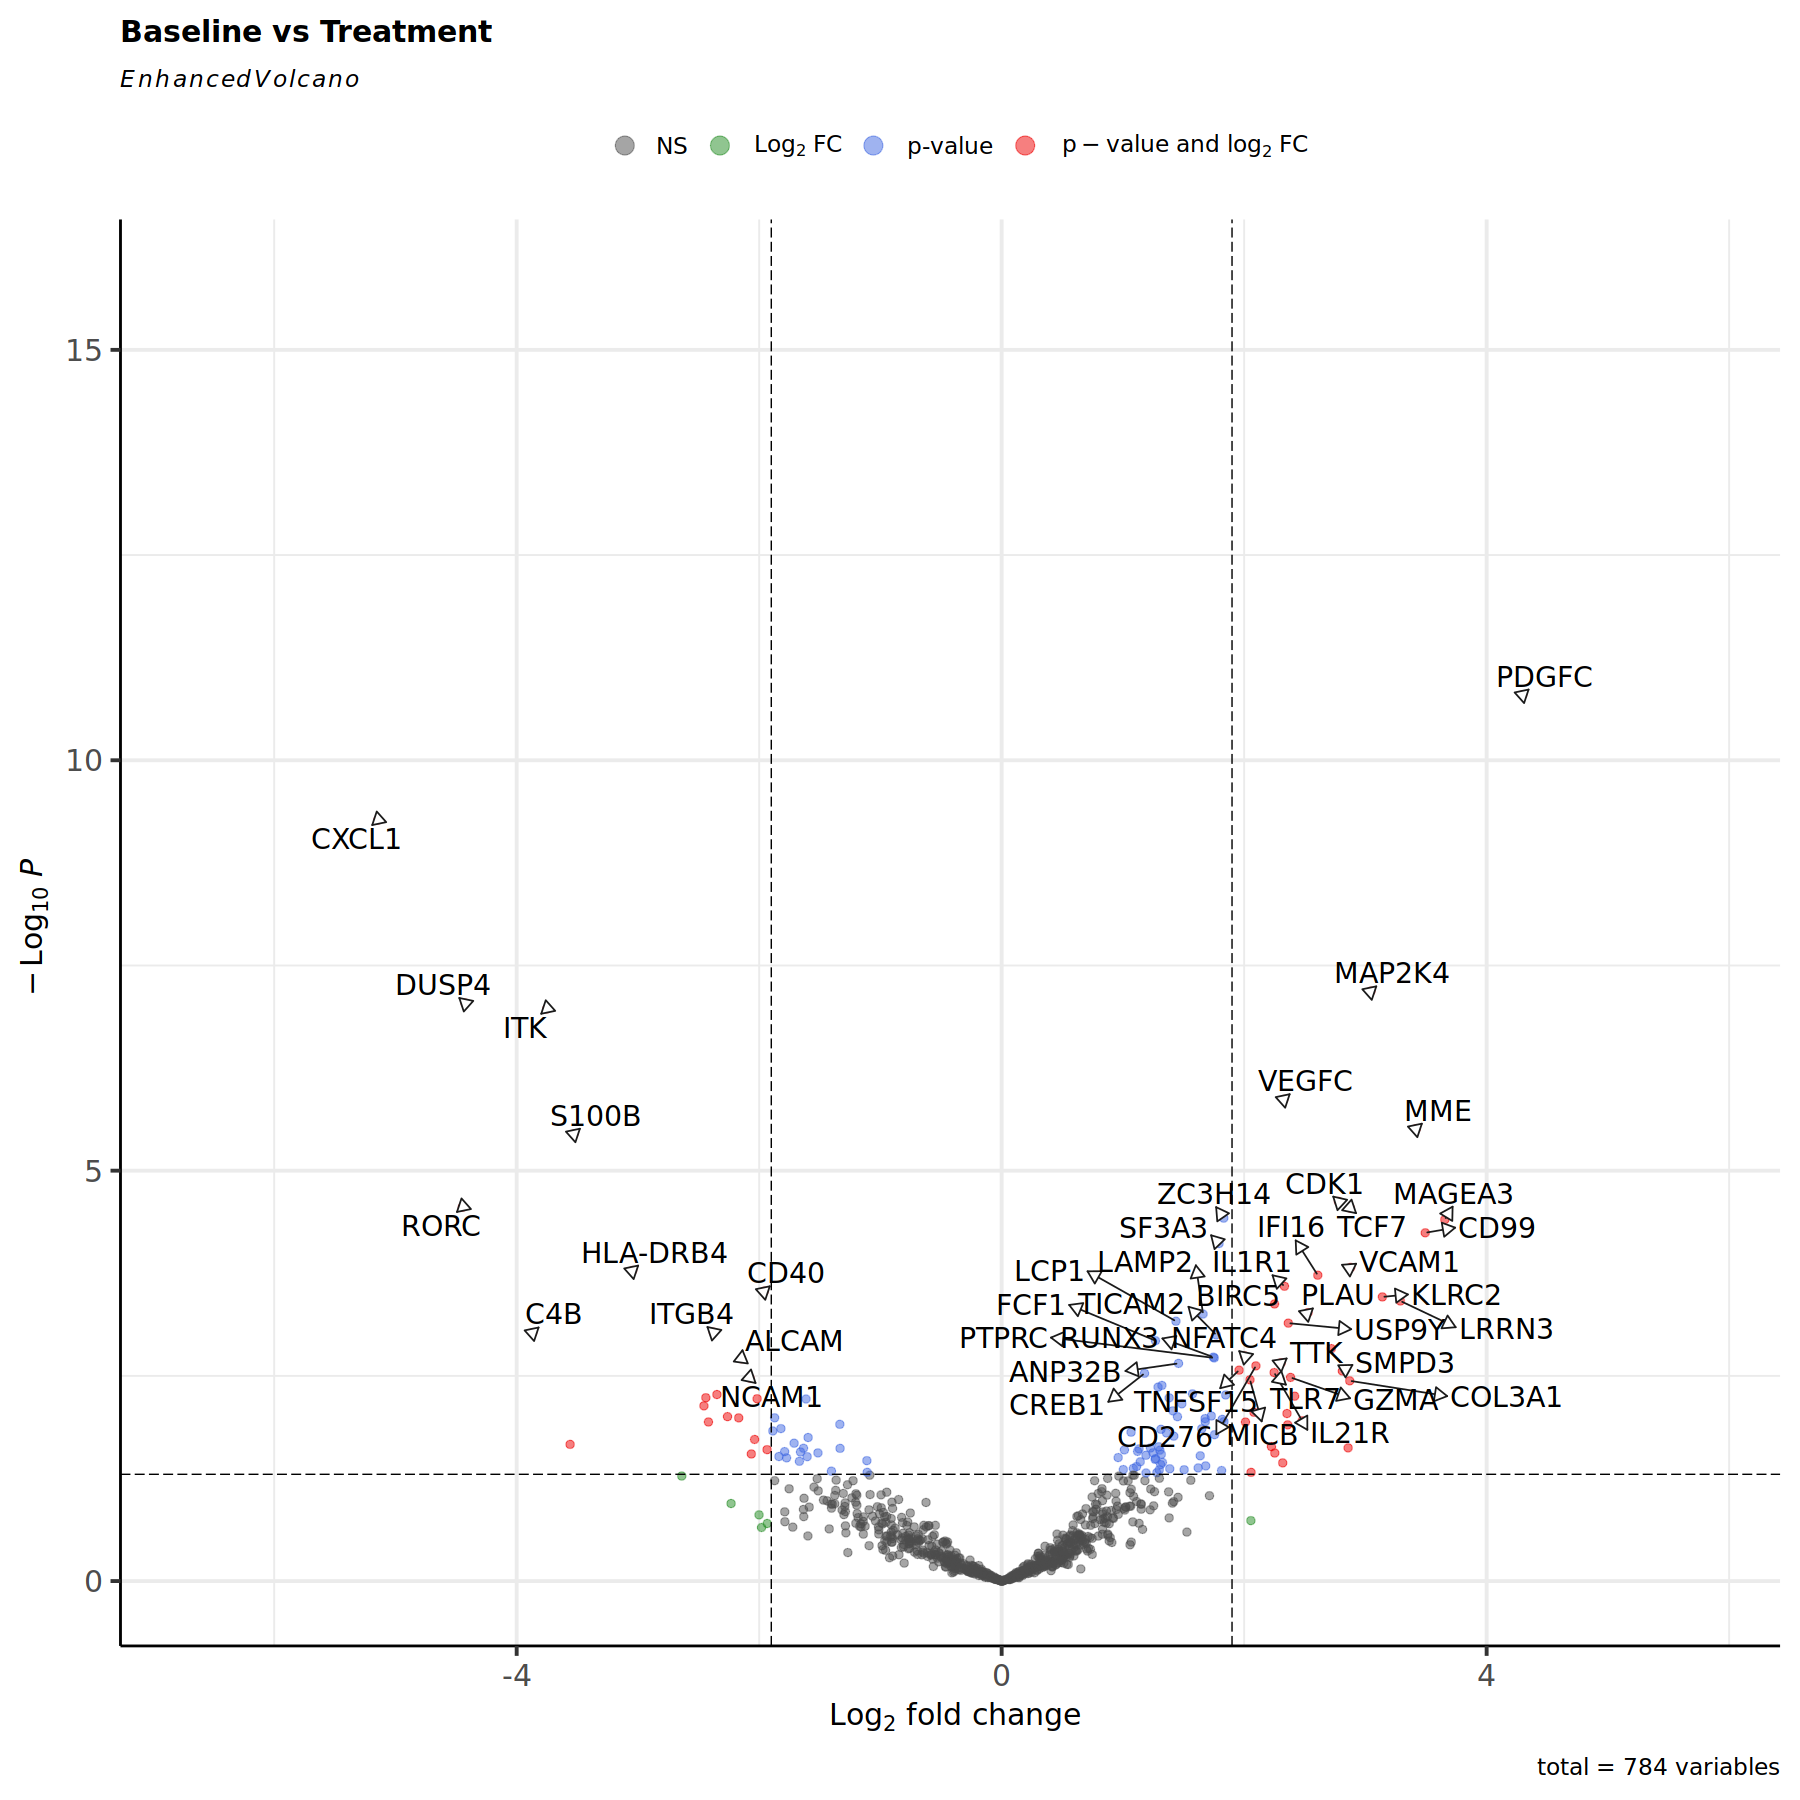

In [52]:
options(repr.plot.width=15, repr.plot.height=15)
EnhancedVolcano(res_valcanoplot2,
                lab = rownames(res_valcanoplot2),
                selectLab = row.names(top_de_genes_2),
                x = 'log2FoldChange',
                y = 'pvalue',
                title = 'Baseline vs Treatment',drawConnectors = TRUE,max.overlaps = 35,
                pCutoff = 0.05,
                FCcutoff = 1.9,
                pointSize = 2.0,
                labSize = 6.0)

In [79]:
pdf("05_Baseline_vs_Treatment_volcano_plot_(with_matched_cases).pdf", width=15, height=15)
print(EnhancedVolcano(res_valcanoplot2,
                lab = rownames(res_valcanoplot2),
                selectLab = row.names(top_de_genes_2),
                x = 'log2FoldChange',
                y = 'pvalue',
                title = 'Baseline vs Treatment',drawConnectors = TRUE,max.overlaps = 35,
                pCutoff = 0.05,
                FCcutoff = 1.9,
                pointSize = 2.0,
                labSize = 6.0))
graphics.off()

In [80]:
goi = c('CXCL1', 'DUSP4', 'PDGFC', 'MAP2K4')

In [81]:
colData(dds_w1_2)
tcounts <- t(log2((counts(dds_w1_2[goi, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(dds_w1_2), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goi)+1):ncol(.))

DataFrame with 34 rows and 13 columns
                                                Conditions  Diagnosis      pid
                                               <character>   <factor> <factor>
20230616_210462891024_K1241-B_02.RCC  Soft Tissue Sarcoma   Treatment    K1241
20230707_210462871024_K1241-Tx_09.RCC Soft Tissue Sarcoma   Baseline     K1241
20230616_210462891024_K1628-B_03.RCC  Soft Tissue Sarcoma   Treatment    K1628
20230707_210462871024_K1628-Tx_10.RCC Soft Tissue Sarcoma   Baseline     K1628
20230616_210462891024_K2032-B_05.RCC  Soft Tissue Sarcoma   Treatment    K2032
...                                                    ...        ...      ...
20230707_210462901024_K4360-Tx_11.RCC        Osteosarcoma   Baseline     K4360
20230707_210462871024_K4368-B_06.RCC  Soft Tissue Sarcoma   Treatment    K4368
20230707_210462901024_K4368-Tx_12.RCC Soft Tissue Sarcoma   Baseline     K4368
20230616_210462891024_K853-B_01.RCC          Osteosarcoma   Treatment    K853 
20230707_21046

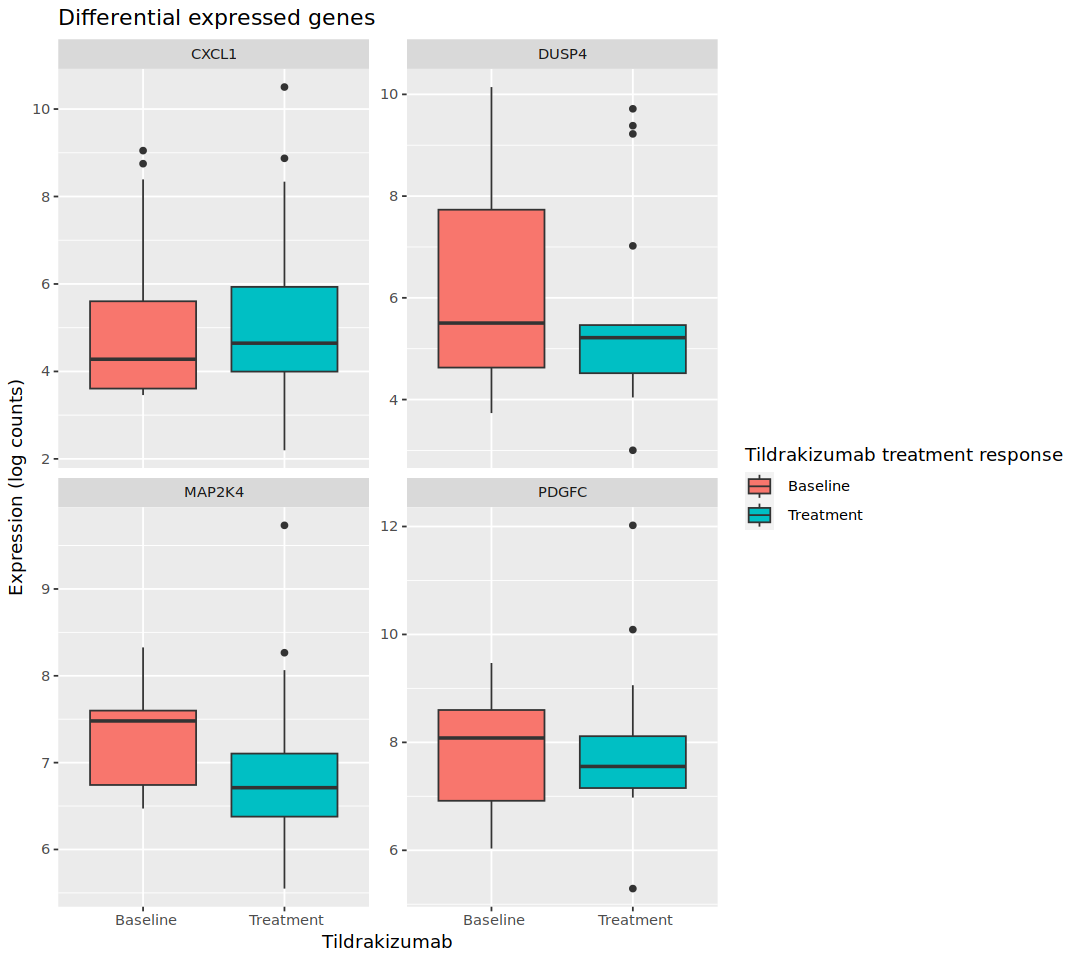

In [86]:
options(repr.plot.width=9, repr.plot.height=8)
sd_boxplot = ggplot(tcounts, aes(Diagnosis, expression, fill=Diagnosis)) + 
  geom_boxplot() + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Tildrakizumab", 
       y="Expression (log counts)", 
       fill="Tildrakizumab treatment response", 
       title="Differential expressed genes")
sd_boxplot

In [87]:
pdf("05_Baseline_vs_Treatment_box_plot_top_DE_genes_(with_matched_cases).pdf", width=8, height=8)
print(sd_boxplot)
graphics.off()